# Use Case 3: Associating Clinical Variables with Acetylation

In this use case, we aim to analyze acetylation data with a clinical attribute, specifically "histologic_type". Our goal is to identify acetylation sites that differ significantly in frequency between non-tumor, serous and endometrial cells.

# Step 1: Import Packages and Load Data

First, we'll import the necessary packages, including the cptac package, and load the Endometrial dataset.

In [1]:
import pandas as pd
import numpy as np
import scipy.stats
import statsmodels.stats.multitest
import matplotlib.pyplot as plt
import seaborn as sns
import math
import cptac
import cptac.utils as ut

en = cptac.Ucec()

# Step 2: Understanding the Acetylproteomic Dataframe

The Endometrial acetylproteomic dataframe has a multiindex. The 'Name' index lists the gene of interest, 'Site' index shows the site of acetylation, and 'Peptide' index shows the peptide sequence where the modification took place. 'Database_ID' differentiates entries with the same gene name. After joining with other dataframes, we typically drop 'Database_ID' for easier data manipulation.

In [2]:
en.get_acetylproteomics('umich')

Name                      ARF5             FKBP4                    \
Site                      K109              K181              K213   
Peptide     VQESADELQKMLQEDELR           DKLFDQR      MEKGEHSIVYLK   
Database_ID  ENSP00000000233.5 ENSP00000001008.4 ENSP00000001008.4   
Patient_ID                                                           
C3L-00006                  NaN               NaN               NaN   
C3L-00008                  NaN         13.420601               NaN   
C3L-00032                  NaN               NaN         15.060923   
C3L-00084                  NaN               NaN               NaN   
C3L-00090                  NaN               NaN               NaN   
...                        ...               ...               ...   
NX5.N                14.617941               NaN         15.496429   
NX6.N                14.533201               NaN         15.618387   
NX7.N                14.289658               NaN         15.657418   
NX8.N                      NaN         13.118452               NaN   
NX9.N                      NaN         12.792899               NaN   

Name                                                                \
Site                     K234               K266              K294   
Peptide          EKFQIPPNAELK ESWEMNSEEKLEQSTIVK  QALLQYKK;QALLQYK   
Database_ID ENSP00000001008.4  ENSP00000001008.4 ENSP00000001008.4   
Patient_ID                                                           
C3L-00006                 NaN                NaN               NaN   
C3L-00008                 NaN                NaN               NaN   
C3L-00032                 NaN                NaN               NaN   
C3L-00084                 NaN                NaN         12.336663   
C3L-00090                 NaN                NaN               NaN   
...                       ...                ...               ...   
NX5.N                     NaN                NaN         12.903885   
NX6.N                     NaN                NaN         12.994645   
NX7.N                     NaN                NaN         13.018219   
NX8.N                     NaN                NaN               NaN   
NX9.N                     NaN                NaN               NaN   

Name                                                               \
Site                      K35              K354               K76   
Peptide               QDEGVLK    ALELDSNNEKGLFR         DKFSFDLGK   
Database_ID ENSP00000001008.4 ENSP00000001008.4 ENSP00000001008.4   
Patient_ID                                                          
C3L-00006                 NaN               NaN               NaN   
C3L-00008                 NaN               NaN               NaN   
C3L-00032                 NaN               NaN               NaN   
C3L-00084                 NaN               NaN               NaN   
C3L-00090                 NaN         16.483674               NaN   
...                       ...               ...               ...   
NX5.N               11.666652               NaN               NaN   
NX6.N               12.320025               NaN               NaN   
NX7.N               12.048218               NaN               NaN   
NX8.N                     NaN               NaN               NaN   
NX9.N                     NaN               NaN               NaN   

Name                   ZNF195  ...             PDIA4  \
Site                     K497  ...              K570   
Peptide             THTGEKPYK  ...      QLEPVYNSLAKK   
Database_ID ENSP00000005082.9  ... ENSP00000499129.1   
Patient_ID                     ...                     
C3L-00006                 NaN  ...               NaN   
C3L-00008                 NaN  ...               NaN   
C3L-00032                 NaN  ...               NaN   
C3L-00084                 NaN  ...               NaN   
C3L-00090                 NaN  ...               NaN   
...                       ...  ...               ...   
NX5.N                     NaN  ...   

# Step 3: Choose Clinical Attribute and Join Dataframes

For this use case, we'll use the 'histologic_type' clinical attribute to identify differences in acetylation sites between "endometrioid" and "serous" cancer cells. We'll join this clinical attribute with our acetylation dataframe using the en.join_metadata_to_omics method

In [3]:
#Set desired attribute to variable 'clinical_attribute'
clinical_attribute = "histologic_type"

#Join attribute with acetylation dataframe
clinical_and_acetylation = en.join_metadata_to_omics(metadata_name='clinical',
                                                    omics_name='acetylproteomics',
                                                    omics_source='umich',
                                                    metadata_source='mssm',
                                                    metadata_cols=clinical_attribute)
clinical_and_acetylation

Name               histologic_type ARF5_umich_acetylproteomics  \
Site                                                      K109   
Peptide                                     VQESADELQKMLQEDELR   
Patient_ID                                                       
C3L-00006   Endometrioid carcinoma                         NaN   
C3L-00008   Endometrioid carcinoma                         NaN   
C3L-00032   Endometrioid carcinoma                         NaN   
C3L-00084   Endometrioid carcinoma                         NaN   
C3L-00090   Endometrioid carcinoma                         NaN   
...                            ...                         ...   
NX5.N                          NaN                   14.617941   
NX6.N                          NaN                   14.533201   
NX7.N                          NaN                   14.289658   
NX8.N                          NaN                         NaN   
NX9.N                          NaN                         NaN   

Name       FKBP4_umich_acetylproteomics                            \
Site                               K181         K213         K234   
Peptide                         DKLFDQR MEKGEHSIVYLK EKFQIPPNAELK   
Patient_ID                                                          
C3L-00006                           NaN          NaN          NaN   
C3L-00008                     13.420601          NaN          NaN   
C3L-00032                           NaN    15.060923          NaN   
C3L-00084                           NaN          NaN          NaN   
C3L-00090                           NaN          NaN          NaN   
...                                 ...          ...          ...   
NX5.N                               NaN    15.496429          NaN   
NX6.N                               NaN    15.618387          NaN   
NX7.N                               NaN    15.657418          NaN   
NX8.N                         13.118452          NaN          NaN   
NX9.N                         12.792899          NaN          NaN   

Name                                                                      \
Site                     K266             K294        K35           K354   
Peptide    ESWEMNSEEKLEQSTIVK QALLQYKK;QALLQYK    QDEGVLK ALELDSNNEKGLFR   
Patient_ID                                                                 
C3L-00006                 NaN              NaN        NaN            NaN   
C3L-00008                 NaN              NaN        NaN            NaN   
C3L-00032                 NaN              NaN        NaN            NaN   
C3L-00084                 NaN        12.336663        NaN            NaN   
C3L-00090                 NaN              NaN        NaN      16.483674   
...                       ...              ...        ...            ...   
NX5.N                     NaN        12.903885  11.666652            NaN   
NX6.N                     NaN        12.994645  12.320025            NaN   
NX7.N                     NaN        13.018219  12.048218            NaN   
NX8.N                     NaN              NaN        NaN            NaN   
NX9.N                     NaN              NaN        NaN            NaN   

Name                  ... PDIA4_umich_acetylproteomics  \
Site             K76  ...                         K570   
Peptide    DKFSFDLGK  ...                 QLEPVYNSLAKK   
Patient_ID            ...                                
C3L-00006        NaN  ...                          NaN   
C3L-00008        NaN  ...                          NaN   
C3L-00032        NaN  ...                          NaN   
C3L-00084        NaN  ...                          NaN   
C3L-00090        NaN  ...                          NaN   
...              ...  ...                          ...   
NX5.N            NaN  ...                          NaN   
NX6.N            NaN  ...                          NaN   
NX7.N            NaN  ...                          NaN   
NX8.N            NaN  ...                          NaN   
NX9.N            NaN

 Now, we'll drop the 'Peptide' level and flatten the 'Site' level, appending the 'Site' to the column names.

In [4]:
# Use the cptac.utils.reduce_multiindex function to combine the multiple column levels
clinical_and_acetylation = ut.reduce_multiindex(clinical_and_acetylation, levels_to_drop="Peptide")
clinical_and_acetylation = ut.reduce_multiindex(clinical_and_acetylation, flatten=True)

clinical_and_acetylation

cptac warning: Due to dropping the specified levels, dataframe now has 587 duplicated column headers. (/var/folders/n2/95tlbmw5173fm8yjh4ffxggr0000gn/T/ipykernel_72326/1181336117.py, line 2)


Name,histologic_type,ARF5_umich_acetylproteomics_K109,FKBP4_umich_acetylproteomics_K181,FKBP4_umich_acetylproteomics_K213,FKBP4_umich_acetylproteomics_K234,FKBP4_umich_acetylproteomics_K266,FKBP4_umich_acetylproteomics_K294,FKBP4_umich_acetylproteomics_K35,FKBP4_umich_acetylproteomics_K354,FKBP4_umich_acetylproteomics_K76,...,PDIA4_umich_acetylproteomics_K570,PDIA4_umich_acetylproteomics_K611,PDIA4_umich_acetylproteomics_K637,AC004706.3_umich_acetylproteomics_K21,K102K105,K105,WIZ_umich_acetylproteomics_K16,WIZ_umich_acetylproteomics_K638,K228,K304
Patient_ID,,,,,,,,,,,,,,,,,,,,,
C3L-00006,Endometrioid carcinoma,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,15.945484,NaN,NaN,NaN,NaN,NaN,22.290219
C3L-00008,Endometrioid carcinoma,NaN,13.420601,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,16.790586,NaN,NaN,14.147555,12.664316,NaN,22.236406
C3L-00032,Endometrioid carcinoma,NaN,NaN,15.060923,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,15.952557,NaN,NaN,NaN,NaN,14.351192,21.437865
C3L-00084,Endometrioid carcinoma,NaN,NaN,NaN,NaN,NaN,12.336663,NaN,NaN,NaN,...,NaN,NaN,12.251376,14.506364,NaN,NaN,NaN,NaN,NaN,25.212475
C3L-00090,Endometrioid carcinoma,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.483674,NaN,...,NaN,NaN,NaN,16.116837,13.641868,NaN,NaN,11.869961,NaN,21.68762
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NX5.N,NaN,14.617941,NaN,15.496429,NaN,NaN,12.903885,11.666652,NaN,NaN,...,NaN,NaN,NaN,17.23143,NaN,NaN,NaN,NaN,NaN,23.490334
NX6.N,NaN,14.533201,NaN,15.618387,NaN,NaN,12.994645,12.320025,NaN,NaN,...,NaN,NaN,NaN,17.188642,NaN,NaN,NaN,NaN,NaN,23.308924
NX7.N,NaN,14.289658,NaN,15.657418,NaN,NaN,13.018219,12.048218,NaN,NaN,...,NaN,NaN,NaN,17.511215,NaN,NaN,NaN,NaN,NaN,23.759263


# Step 4: Format Dataframe to Compare Acetylproteomic Sites Between Histologic Types

In [5]:
clinical_attribute = "histologic_type"
#Show possible variations of histologic_type
clinical_and_acetylation[clinical_attribute].unique()

array(['Endometrioid carcinoma', 'Serous carcinoma',
       'Clear cell carcinoma', 'Mixed cell adenocarcinoma', nan],
      dtype=object)

In this step, we will make two different dataframes for "Endometrioid" and "Serous" cancer types, as well as fill the NaN columns with "Non-Tumor."

In [6]:
#Make dataframes with only endometrioid and only serous data in order to compare 
endom = clinical_and_acetylation.loc[clinical_and_acetylation[clinical_attribute] == "Endometrioid carcinoma"]
serous = clinical_and_acetylation.loc[clinical_and_acetylation[clinical_attribute] == "Serous carcinoma"]
#Here is where we set the NaN values to "Non_Tumor"
clinical_and_acetylation[[clinical_attribute]] = clinical_and_acetylation[[clinical_attribute]].fillna(
    value="Non_Tumor")

Now that we have our different dataframes, we want to make sure that the amount of data we are using for each site is significant. Since there are fewer patients with "serous" tumors than with "endometrioid," we will check to make sure that we have at least five values for each acetylation site that we are comparing that have a measurement of intensity for serous patients. We will remove every acetylation site from our dataframe that doesn't have at least five values among the serous patients.

In [7]:
#Remove every column that doesn't have at least 5 values among the serous patients
print("Total Sites: ", len(serous.columns) - 1)
sites_to_remove = []
for num in range(1, len(serous.columns)):
    serous_site = serous.columns[num]
    one_site = serous[serous_site]
    num_datapoints_ser = one_site.count()
    if num_datapoints_ser.mean() < 5:
        sites_to_remove.append(serous_site)

clinical_and_acetylation = clinical_and_acetylation.drop(sites_to_remove, axis = 1)

#Also remove non-tumor patients from our dataframe to use in comparison, as we want to compare only endometrioid and serous types
clinical_and_acetylation_comparison = clinical_and_acetylation.loc[clinical_and_acetylation['histologic_type'] != 'Non_Tumor']
clinical_and_acetylation_comparison = clinical_and_acetylation_comparison.loc[clinical_and_acetylation_comparison['histologic_type'] != 'Mixed cell adenocarcinoma']
clinical_and_acetylation_comparison = clinical_and_acetylation_comparison.loc[clinical_and_acetylation_comparison['histologic_type'] != 'Clear cell carcinoma']


print("Removed: ", len(sites_to_remove))
print("Remaining Sites: ", len(clinical_and_acetylation_comparison.columns) - 1)
print("Adjusted p-value cutoff will be: ", .05/(len(clinical_and_acetylation_comparison.columns)-1))

Total Sites:  11790
Removed:  5442
Remaining Sites:  6348
Adjusted p-value cutoff will be:  7.876496534341525e-06


# Step 5: Compare Endometrioid and Serous Values

We will now call the wrap_ttest method, which will loop through the data and compare endometrioid versus serous data for each acetylation site. If we find a site that is significantly different, we will add it to a dataframe, with its p-value. The default alpha used is .05, which will be adjusted to account for multiple testing using a bonferroni correction, dividing alpha by the number of comparisons that will occur (the number of comparison columns).

In [8]:
#Make list of all remaining sites in dataframe to pass to wrap_ttest function
columns_to_compare = list(clinical_and_acetylation_comparison.columns)

#Remove the "Histologic_type" column (at index 0) from this list
columns_to_compare = columns_to_compare[1:]
# print(columns_to_compare)

clinical_and_acetylation_comparison = clinical_and_acetylation_comparison.loc[:,~clinical_and_acetylation_comparison.columns.duplicated()]
#Perform ttest on each column in dataframe
significant_sites_df = ut.wrap_ttest(df=clinical_and_acetylation_comparison, label_column="histologic_type", comparison_columns=columns_to_compare)

#List significant results
significant_sites_df

,Comparison,P_Value
0,PCBP1_umich_acetylproteomics_K31,0.000398
1,FOXA2_umich_acetylproteomics_K274,0.000951
2,TBL1XR1_umich_acetylproteomics_K102,0.001964
3,CNBP_umich_acetylproteomics_K85,0.004430
4,JADE3_umich_acetylproteomics_K735,0.007308
5,EYA2_umich_acetylproteomics_K248,0.009880
6,RAB1A_umich_acetylproteomics_K131,0.012228
7,DYNC1H1_umich_acetylproteomics_K1649,0.014876
8,VDAC1_umich_acetylproteomics_K224,0.022864


# Step 6: Graph Results

Now that we have eight acetylation sites that differ significantly between endometrioid and serous intensities, we will graph a couple of them using a boxplot and a stripplot in order to visually see the difference, as well as compare with normal cells. First we'll remove some extreme outliers.

In [9]:
# Define a function to calculate IQR and lower and upper bounds for extreme outliers
def calculate_iqr_and_bounds_extreme(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1

    # Define bounds for extreme outliers
    lower_bound = Q1 - 3.0 * IQR
    upper_bound = Q3 + 3.0 * IQR

    return lower_bound, upper_bound

Now we will visualize the data while considering extreme outliers. Extreme outliers are calculated by expanding the IQR range to 3 times instead of the usual 1.5 times.

TtestResult(statistic=5.653510545875068, pvalue=1.520752350373057e-07, df=99.0)


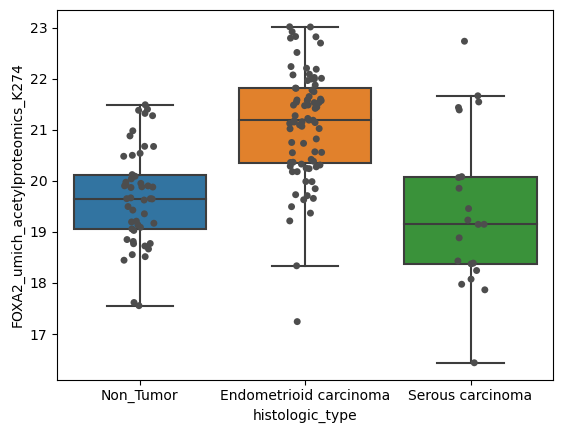

TtestResult(statistic=-5.487492982044729, pvalue=3.1403534632193126e-07, df=99.0)


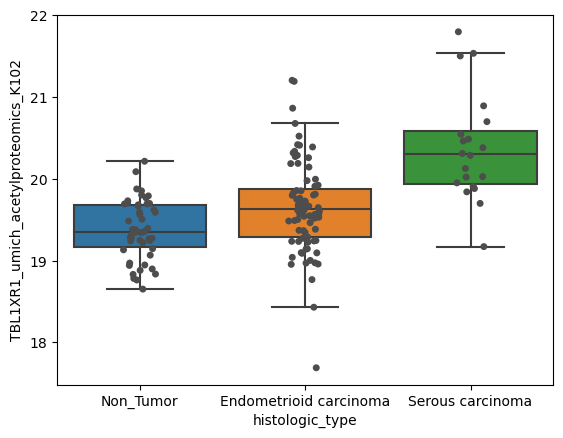

In [24]:
# Now we will visualize the data while considering extreme outliers.
# Extreme outliers are calculated by expanding the IQR range to 3 times instead of the usual 1.5 times.
for site in ['FOXA2_umich_acetylproteomics_K274', 'TBL1XR1_umich_acetylproteomics_K102']:
    # Convert to numeric and drop NA
    clinical_and_acetylation[site] = pd.to_numeric(clinical_and_acetylation[site], errors='coerce')

    # Calculate lower and upper bounds for the specific column
    lower_bound, upper_bound = calculate_iqr_and_bounds_extreme(clinical_and_acetylation[site])

    # Create a new dataframe without extreme outliers
    clinical_and_acetylation_no_extreme_outliers = clinical_and_acetylation[(clinical_and_acetylation[site] >= lower_bound) & 
                                                                            (clinical_and_acetylation[site] <= upper_bound)]
    
    # Convert data to list format to make it compatible with t-test
    endomList = endom[site].tolist()
    serousList = serous[site].tolist()
    
    # Perform t-test and print results
    print(scipy.stats.ttest_ind(endomList, serousList))

    # Create boxplot and stripplot
    sns.boxplot(x=clinical_attribute, y=site, data=clinical_and_acetylation_no_extreme_outliers, showfliers=False, 
                order=["Non_Tumor", "Endometrioid carcinoma", "Serous carcinoma"])
    sns.stripplot(x=clinical_attribute, y=site, data=clinical_and_acetylation_no_extreme_outliers, color='.3', 
                  order=["Non_Tumor", "Endometrioid carcinoma", "Serous carcinoma"])
    plt.show()